In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
!pip install pyspark

In [3]:
# standard libraries
import pandas as pd
import matplotlib.pyplot as plt

# PySpark libraries
from pyspark.sql import SparkSession
import pyspark.sql.functions as sql_f
from pyspark.sql.types import *
from pyspark.sql.functions import to_date, datediff, floor, col, avg, substring

# DL/ML libraries
from sklearn.metrics import accuracy_score
spark = SparkSession.builder.getOrCreate()


In [4]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import unix_timestamp

for working in GCP

In [ ]:
filepath = "gs://bucket-sum-mg/csv/"

In [ ]:
!ls

output	sample_data  synthea-with-dependencies.jar


In [ ]:
!hadoop fs -mkdir -p /csv
!gsutil -m cp -r gs://bucket-sum-mg/csv/* .
!hadoop fs -put -f *.csv /csv/

/bin/bash: line 1: hadoop: command not found
ServiceException: 401 Anonymous caller does not have storage.objects.list access to the Google Cloud Storage bucket. Permission 'storage.objects.list' denied on resource (or it may not exist).
CommandException: 1 file/object could not be transferred.
/bin/bash: line 1: hadoop: command not found


In [ ]:
path = "hdfs://st446-sum-mg-m:8020/csv/"

## 1) Loading the data

In [5]:
# @title Synthea Patient Generator (CSV Version)
import os
from IPython.display import clear_output

# Configuration
num_patients = 5  # @param {type:"integer"}
state = "Massachusetts"  # @param ["Massachusetts", "California", "New York", "Texas", "Florida"]
age_range = "30-85"  # @param {type:"string"}
seed = 12345  # @param {type:"integer"}

# Install Java
!sudo apt-get update
!sudo apt-get install -y openjdk-11-jdk-headless
clear_output()
print("✅ Java installed")

# Download Synthea
!wget -q https://github.com/synthetichealth/synthea/releases/download/master-branch-latest/synthea-with-dependencies.jar
clear_output()
print("✅ Synthea downloaded")

# Generate patients (using proper string substitution)
!java -jar synthea-with-dependencies.jar \
  -p {num_patients} \
  -s {seed} \
  -a "{age_range}" \
  --exporter.baseDirectory "./output" \
  --exporter.fhir.export=False \
  --exporter.csv.export=True \
  {state}

# Verify output
csv_output_path = "./output/csv"
if os.path.exists(csv_output_path):
    csv_files = [f for f in os.listdir(csv_output_path) if f.endswith('.csv')]
    if csv_files:
        print(f"\n🎉 Success! Generated {len(csv_files)} CSV files:")
        for file in csv_files[:5]:  # Show first 5 files
            print(f"- {file}")
        print(f"\nTotal records across all CSV files: {num_patients} patients")
    else:
        print("\n⚠ CSV directory exists but contains no CSV files")
else:
    print("\n❌ Generation failed. Common fixes:")
    print("1. Try reducing patient count (start with 10)")
    print("2. Check Java version:")
    !java -version
    print("3. Disk space:")
    !df -h

✅ Synthea downloaded
SLF4J: No SLF4J providers were found.
SLF4J: Defaulting to no-operation (NOP) logger implementation
SLF4J: See http://www.slf4j.org/codes.html#noProviders for further details.
Scanned 88 modules and 152 submodules.
Loading submodule modules/allergies/allergy_panel.json
Loading submodule modules/allergies/drug_allergy_incidence.json
Loading submodule modules/allergies/environmental_allergy_incidence.json
Loading submodule modules/allergies/food_allergy_incidence.json
Loading submodule modules/allergies/immunotherapy.json
Loading submodule modules/allergies/outgrow_env_allergies.json
Loading submodule modules/allergies/outgrow_food_allergies.json
Loading submodule modules/allergies/severe_allergic_reaction.json
Loading submodule modules/anemia/anemia_sub.json
Loading submodule modules/breast_cancer/chemotherapy_breast.json
Loading submodule modules/breast_cancer/hormone_diagnosis.json
Loading submodule modules/breast_cancer/hormonetherapy_breast.json
Loading submodul

In [7]:
#for working in google colab

path = '/content/output/csv/'

## 2) Creating the spark dataframes

In [8]:
#patient
observations = spark.read.csv(path+"observations.csv", header=True)
patient = spark.read.csv(path+"patients.csv", header=True) #includes healthcare coverage

#medical
careplans = spark.read.csv(path+"careplans.csv", header=True)
conditions = spark.read.csv(path+"conditions.csv", header=True)
procedures=spark.read.csv(path+"procedures.csv", header=True)
encounters = spark.read.csv(path+"encounters.csv", header=True)
medications = spark.read.csv(path+"medications.csv", header=True)

#insurance and hospital
payer_transitions=spark.read.csv(path+"payer_transitions.csv", header=True)
payers=spark.read.csv(path+"payers.csv", header=True)
providers=spark.read.csv(path+"providers.csv", header=True)
organizations=spark.read.csv(path+"organizations.csv", header=True)

## 3) Cleaning dataframes and renaming variables

In [9]:
# renaming columns

patient = (
    patient.withColumnRenamed("Id", "patient_id")
           .withColumnRenamed("MARITAL", "patient_marital")
           .withColumnRenamed("RACE", "patient_race")
           .withColumnRenamed("ETHNICITY", "patient_ethnicity")
           .withColumnRenamed("GENDER", "patient_gender")
           .withColumnRenamed("ZIP", "patient_zip")
)

encounters = (
    encounters.withColumnRenamed("PATIENT", "patient_id")
              .withColumnRenamed("Id", "encounter_id")
              .withColumnRenamed("DESCRIPTION", "encounter_discription")
              .withColumnRenamed("CODE", "encounter_code")
              .withColumnRenamed("START", "encounter_start")
              .withColumn("encounter_start", to_date("encounter_start"))
              .withColumnRenamed("STOP", "encounter_stop")
              .withColumn("encounter_stop", to_date("encounter_stop"))
              .withColumn("PATIENT COST", col("TOTAL_CLAIM_COST") - col("PAYER_COVERAGE"))
              .withColumnRenamed("PAYER", "payer_id")
              .withColumnRenamed("ORGANIZATION", "organization_id")
              .withColumnRenamed("PROVIDER", "provider_id")
)

careplans = (
    careplans.withColumnRenamed("PATIENT", "patient_id")
             .withColumnRenamed("Id", "careplan_id")
             .withColumnRenamed("ENCOUNTER", "encounter_id")
             .withColumnRenamed("DESCRIPTION", "careplan_descriptions")
             .withColumnRenamed("CODE", "careplan_code")
)

procedures = (
    procedures.withColumnRenamed("PATIENT", "patient_id")
              .withColumnRenamed("ENCOUNTER", "encounter_id")
              .withColumnRenamed("DESCRIPTION", "procedure_descriptions")
              .withColumnRenamed("CODE", "procedure_code")
              .withColumnRenamed("DATE", "procedure_date")
              .withColumnRenamed("BASE_COST", "procedure_cost")
)

conditions = (
    conditions.withColumnRenamed("PATIENT", "patient_id")
              .withColumnRenamed("ENCOUNTER", "encounter_id")
              .withColumnRenamed("DESCRIPTION", "condition_description")
              .withColumnRenamed("CODE", "condition_code")
              .withColumnRenamed("START", "condition_start")
              .withColumnRenamed("END", "condition_end")
)

observations = (
    observations.withColumnRenamed("PATIENT", "patient_id")
                .withColumnRenamed("ENCOUNTER", "encounter_id")
                .withColumnRenamed("DATE", "observation_date")
                .withColumn("observation_date", to_date("observation_date"))
)

medications = (
    medications.withColumnRenamed("START", "medication_start")
               .withColumn("medication_start", to_date("medication_start"))
               .withColumnRenamed("STOP", "medication_stop")
               .withColumn("medication_stop", to_date("medication_stop"))
               .withColumnRenamed("PATIENT", "patient_id")
               .withColumnRenamed("PAYER", "payer_id")
               .withColumnRenamed("ENCOUNTER", "encounter_id")
               .withColumnRenamed("CODE", "medication_code")
               .withColumnRenamed("DESCRIPTION", "medication_description")
)

payer_transitions = (
    payer_transitions.withColumnRenamed("PATIENT", "patient_id")
                     .withColumnRenamed("PAYER", "payer_id")
)

payers = (
    payers.withColumnRenamed("Id", "payer_id")
          .withColumnRenamed("NAME", "payer_name")
          .withColumnRenamed("OWNERSHIP", "payer_ownership")
)

providers = (
    providers.withColumnRenamed("Id", "provider_id")
             .withColumnRenamed("SPECIALITY", "provider_specialty")
)

organizations = (
    organizations.withColumnRenamed("Id", "organization_id")
                 .withColumnRenamed("NAME", "organization_name")
                 .withColumnRenamed("ZIP", "organization_zip")
                 .withColumn("organization_zip", substring(col("organization_zip").cast("string"), 1, 5))
)

In [10]:
#can do this too
encounters = (
    encounters
    .join(payers.select("payer_id", "payer_name", "payer_ownership"), on="payer_id", how="left")
    .join(organizations.select("organization_id", "organization_name", "organization_zip"), on="organization_id", how="left")
    .join(providers.select("provider_id", "provider_specialty"), on="provider_id", how="left")
    .join(procedures.select("encounter_id", "procedure_descriptions", "procedure_code"), on="encounter_id", how="left")
    .join(patient.select("patient_id", "BIRTHDATE", "patient_marital", "patient_race", "patient_ethnicity", "patient_gender", "patient_zip"), on="patient_id", how="left")
    .withColumn("age_at_encounter", floor(datediff(col("encounter_start"), col("BIRTHDATE")) / 365.25))
)

In [ ]:
# Merge the payer information into the encounters DataFrame
encounters = encounters.join(payers.select('payer_id', 'payer_name', 'payer_ownership'), on='payer_id', how='left')


In [ ]:
encounters = encounters.join(organizations.select('organization_id', 'organization_name', 'organization_zip'), on='organization_id', how='left')

In [ ]:
encounters = encounters.join(providers.select('provider_id', 'provider_specialty'), on='provider_id', how='left')

In [ ]:
encounters = encounters.join(procedures.select('encounter_id','procedure_descriptions','procedure_code'), on='encounter_id', how='left')

In [ ]:
encounters = encounters.join(patient.select('patient_id','BIRTHDATE','patient_marital','patient_race','patient_ethnicity','patient_gender','patient_zip'), on='patient_id', how='left')


In [11]:
# Calculate the age at the time of the encounter
encounters = encounters.withColumn("age_at_encounter", datediff(col("encounter_start"), col("BIRTHDATE")) / 365.25)

# Apply the floor function to the 'age_at_encounter' column
encounters = encounters.withColumn("age_at_encounter", floor(col("age_at_encounter")))

In [12]:
encounters.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+--------------+--------------+--------------+---------------------+-------------------+----------------+--------------+----------+--------------------+------------------+------------+---------------+--------------------+----------------+------------------+----------------------+--------------+----------+---------------+------------+-----------------+--------------+-----------+----------------+
|          patient_id|        encounter_id|         provider_id|     organization_id|            payer_id|encounter_start|encounter_stop|ENCOUNTERCLASS|encounter_code|encounter_discription|BASE_ENCOUNTER_COST|TOTAL_CLAIM_COST|PAYER_COVERAGE|REASONCODE|   REASONDESCRIPTION|      PATIENT COST|  payer_name|payer_ownership|   organization_name|organization_zip|provider_specialty|procedure_descriptions|procedure_code| BIRTHDATE|patient_marital|patient_race|patient_ethnicity|patient

In [14]:
from pyspark.sql.functions import col, log1p, regexp_extract

# Step 1: Create PATIENT COST
encounters = encounters.withColumn("PATIENT COST", col("TOTAL_CLAIM_COST") - col("PAYER_COVERAGE"))

# Step 2: Clean zip codes (same as before)
encounters = encounters \
    .withColumn("organization_zip", regexp_extract(col("organization_zip"), r"(\d+)", 1).cast("int")) \
    .withColumn("patient_zip", regexp_extract(col("patient_zip"), r"(\d+)", 1).cast("int"))

# Step 3: Drop rows with missing values
categorical_cols = ["patient_gender", "patient_ethnicity"]
numerical_cols = ["organization_zip", "patient_zip"]
df_clean = encounters.na.drop(subset=categorical_cols + numerical_cols)

# Step 4: Feature preprocessing
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

indexers = [StringIndexer(inputCol=col, outputCol=col + "_idx", handleInvalid="keep") for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=col + "_idx", outputCol=col + "_vec") for col in categorical_cols]

assembler_inputs = [col + "_vec" for col in categorical_cols] + numerical_cols
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")

from pyspark.ml import Pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler])
pipeline_model = pipeline.fit(df_clean)
df_features = pipeline_model.transform(df_clean)

# Step 5: Add log_patient_cost column
df_features = df_features.withColumn("log_patient_cost", log1p(col("PATIENT COST")))


In [16]:
# Train-test split
train, test = df_features.randomSplit([0.8, 0.2], seed=42)

# Define and fit the model
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol="features", labelCol="log_patient_cost")
lr_model = lr.fit(train)

# Predict and evaluate
predictions = lr_model.transform(test)

from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="log_patient_cost", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

print(f"Global Linear Regression RMSE (log scale): {rmse:.4f}")



Global Linear Regression RMSE (log scale): 2.7326


In [18]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

rf = RandomForestRegressor(featuresCol="features", labelCol="log_patient_cost", seed=42)
rf_model = rf.fit(train)

# Step 3: Predict on test set
predictions = rf_model.transform(test)

# Step 4: Evaluate with RMSE (log scale)
evaluator = RegressionEvaluator(labelCol="log_patient_cost", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

print(f"Global Random Forest RMSE (log scale): {rmse:.4f}")

Global Random Forest RMSE (log scale): 2.7157


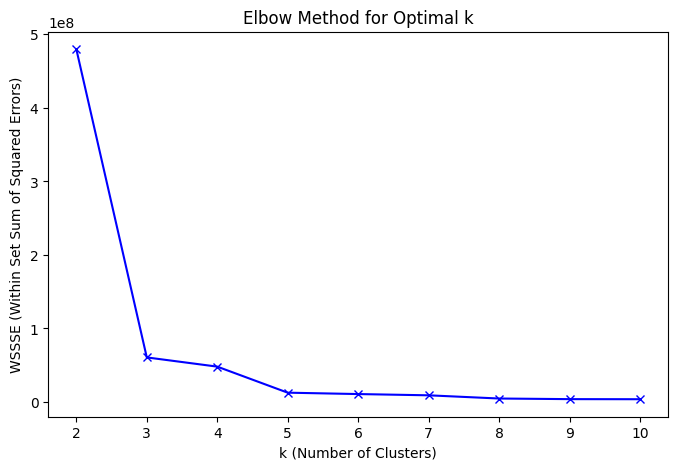

In [20]:
from pyspark.sql.functions import col, regexp_extract, log1p
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline

# Elbow Method to determine optimal k
cost = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(k=k, seed=42, featuresCol="features")
    model = kmeans.fit(df_features)
    cost.append(model.summary.trainingCost)

# Plot elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K, cost, 'bx-')
plt.xlabel('k (Number of Clusters)')
plt.ylabel('WSSSE (Within Set Sum of Squared Errors)')
plt.title('Elbow Method for Optimal k')
plt.show()


In [29]:
#k_optimal = 3
k_optimal = 5

kmeans = KMeans(k=k_optimal, seed=42, featuresCol="features", predictionCol="cluster")
kmeans_model = kmeans.fit(df_features)

# Apply model to assign clusters
result = kmeans_model.transform(df_features)

# View resulting clusters
result.select("patient_id", "cluster").show()

+--------------------+-------+
|          patient_id|cluster|
+--------------------+-------+
|4113255f-4e35-506...|      3|
|4113255f-4e35-506...|      3|
|4113255f-4e35-506...|      3|
|4113255f-4e35-506...|      3|
|4113255f-4e35-506...|      3|
|4113255f-4e35-506...|      3|
|4113255f-4e35-506...|      3|
|4113255f-4e35-506...|      3|
|4113255f-4e35-506...|      3|
|4113255f-4e35-506...|      3|
|4113255f-4e35-506...|      3|
|4113255f-4e35-506...|      3|
|4113255f-4e35-506...|      3|
|4113255f-4e35-506...|      3|
|4113255f-4e35-506...|      3|
|4113255f-4e35-506...|      3|
|4113255f-4e35-506...|      3|
|4113255f-4e35-506...|      3|
|4113255f-4e35-506...|      3|
|4113255f-4e35-506...|      3|
+--------------------+-------+
only showing top 20 rows



In [30]:
from pyspark.sql.functions import avg, stddev, count

# We print the average patient cost, number of patients and standard deviation of patients cost per cluster.
cluster_stats = result.groupBy("cluster").agg(
    avg("PATIENT COST").alias("avg_patient_cost"),
    stddev("PATIENT COST").alias("stddev_patient_cost"),
    count("*").alias("patient_count")
)

cluster_stats.orderBy("cluster").show(truncate=False)

+-------+------------------+-------------------+-------------+
|cluster|avg_patient_cost  |stddev_patient_cost|patient_count|
+-------+------------------+-------------------+-------------+
|0      |423.14679721496947|963.4936929343274  |1149         |
|1      |1349.5353721682836|1182.3055142712656 |309          |
|2      |391.64161764705887|445.8287746345884  |136          |
|3      |4100.2782258064535|7050.50202202318   |124          |
|4      |519.4491573033712 |796.3023521683061  |178          |
+-------+------------------+-------------------+-------------+



In [31]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col

# Create evaluator outside the loop for reuse
evaluator = RegressionEvaluator(labelCol="log_patient_cost", predictionCol="prediction", metricName="rmse")

# Get list of distinct clusters
clusters = [row["cluster"] for row in result.select("cluster").distinct().collect()]

In [32]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
# Loop through each cluster
for c in sorted(clusters):
    print(f"\nLinear Regression — Cluster {c}")

    # Filter data for this cluster
    cluster_df = result.filter(col("cluster") == c)

    # Check if enough data exists
    count = cluster_df.count()
    if count < 30:
        print(f"Not enough data in cluster {c} (only {count} rows), skipping.")
        continue

    # Train-test split
    train, test = cluster_df.randomSplit([0.8, 0.2], seed=42)

    # Fit Linear Regression
    lr = LinearRegression(featuresCol="features", labelCol="log_patient_cost")
    lr_model = lr.fit(train)

    # Predict
    predictions = lr_model.transform(test)

    # Evaluate
    rmse = evaluator.evaluate(predictions)
    print(f"RMSE (log scale): {rmse:.4f} — based on {test.count()} test cases")


Linear Regression — Cluster 0
RMSE (log scale): 3.1938 — based on 199 test cases

Linear Regression — Cluster 1
RMSE (log scale): 1.0583 — based on 47 test cases

Linear Regression — Cluster 2
RMSE (log scale): 1.1737 — based on 24 test cases

Linear Regression — Cluster 3
RMSE (log scale): 3.6316 — based on 22 test cases

Linear Regression — Cluster 4
RMSE (log scale): 2.3565 — based on 29 test cases


In [33]:
# Loop through each cluster
for c in sorted(clusters):
    print(f"\nRandom Forest - Cluster {c}")

    # Filter data for current cluster
    cluster_df = result.filter(col("cluster") == c)

    # Check for enough data
    count = cluster_df.count()
    if count < 30:
        print(f" Not enough data in cluster {c} (only {count} rows), skipping.")
        continue

    # Train-test split
    train, test = cluster_df.randomSplit([0.8, 0.2], seed=42)

    # Define and fit the model
    rf = RandomForestRegressor(featuresCol="features", labelCol="log_patient_cost", seed=42)
    model = rf.fit(train)

    # Predict on test set
    predictions = model.transform(test)

    # Evaluate
    rmse = evaluator.evaluate(predictions)
    print(f"RMSE (log scale): {rmse:.4f} — based on {test.count()} test cases")


Random Forest - Cluster 0
RMSE (log scale): 3.2244 — based on 199 test cases

Random Forest - Cluster 1
RMSE (log scale): 1.0519 — based on 47 test cases

Random Forest - Cluster 2
RMSE (log scale): 1.1710 — based on 24 test cases

Random Forest - Cluster 3
RMSE (log scale): 3.5613 — based on 22 test cases

Random Forest - Cluster 4
RMSE (log scale): 2.3687 — based on 29 test cases
